In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import flax.linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import pandas as pd
import seaborn as sns
from flax.training import train_state
from jax import random

from neurovae import Conv2DVAE, bce_loss, gaussian_kld, load_mnist, plot_digits

sns.set_theme(context="paper", style="darkgrid", rc={"axes.facecolor": "0.96"})
fontsize = "x-large"
params = {
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "legend.handlelength": 2,
}
plt.rcParams.update(params)

In [2]:
latent_dim = 20
output_dim = 784
batch_size = 64
epochs = 3
seed = 42

batches, ds_test = load_mnist(
    batch_size=batch_size,
    drop_remainder=True,
    select_digits=[0, 1, 2, 3],
    as_supervised=False,
    binarized=True,
    shuffle=True,
    shuffle_seed=42,
)

# set values for learning rate scheduler
total_steps = len(batches) * epochs
init_lr = 1e-3
alpha_lr = 1e-2

ds_test = ds_test.reshape(-1, 28, 28, 1)
ds_test = jax.device_put(ds_test)

In [3]:
def model():
    return Conv2DVAE(latent_dim)


def init_model(rng):
    rng, init_key = random.split(rng)

    initial_variables = jnp.ones((batch_size, 28, 28, 1), jnp.float32)
    params = model().init(init_key, initial_variables, rng)["params"]
    del initial_variables, init_key

    lr_schedule = optax.cosine_decay_schedule(init_lr, decay_steps=total_steps, alpha=alpha_lr)
    optimizer = optax.chain(optax.clip(1.0), optax.adamw(lr_schedule))
    # optimizer = optax.adam(learning_rate)

    state = train_state.TrainState.create(
        apply_fn=model().apply,
        params=params,
        tx=optimizer,
    )
    return rng, state


def compute_metrics(recon_x, x, mean, logvar):
    bce = bce_loss(recon_x, x).mean()  # mean over batch
    kld = gaussian_kld(mean, logvar).mean()  # mean over batch
    elbo = bce + kld
    return {"elbo": elbo, "bce": bce, "kld": kld}


@jax.jit
def train_step(state, batch, z_rng):

    def loss_fn(params):
        recon_x, mean, logvar = model().apply({"params": params}, batch, z_rng)
        bce = bce_loss(recon_x, batch).mean()
        kld = gaussian_kld(mean, logvar).mean()
        elbo = bce + kld
        return elbo

    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)


@jax.jit
def eval_f(params, images, z, z_rng):
    def eval_model(vae):
        recon_images, mean, logvar = vae(images, z_rng)

        recon_images_compare = nn.sigmoid(recon_images[:8])
        comparison = jnp.concatenate(
            [
                images[:8],  # .reshape(-1, 28, 28, 1),
                recon_images_compare,  # .reshape(-1, 28, 28, 1),
            ]
        )

        generate_images = vae.generate(z, assumption="bernoulli")
        generate_images = generate_images  # .reshape(-1, 28, 28, 1)
        metrics = compute_metrics(recon_images, images, mean, logvar)
        return metrics, comparison, generate_images

    return nn.apply(eval_model, model())({"params": params})

In [4]:
rng = random.key(seed)
rng, state = init_model(rng)

rng, z_key, eval_rng = random.split(rng, 3)

z = random.normal(z_key, (batch_size, latent_dim))  # prior
del z_key

epoch_metrics = []
for epoch in range(epochs):
    for batch in batches:
        batch = batch.reshape(-1, 28, 28, 1)
        rng, key = random.split(rng)
        state = train_step(state, batch, key)

    metrics, comparison, samples = eval_f(state.params, ds_test, z, eval_rng)
    metrics["epoch"] = epoch + 1
    epoch_metrics.append(metrics)
    print(f"epoch: {epoch + 1}, ELBO: {metrics['elbo']:.4f}, BCE: {metrics['bce']:.4f}, KLD: {metrics['kld']:.4f}")

KeyboardInterrupt: 

2m 37.6 s, 3 epochs

epoch: 1, ELBO: 103.2772, BCE: 77.2623, KLD: 26.0149

epoch: 2, ELBO: 93.4923, BCE: 66.2024, KLD: 27.2900

epoch: 3, ELBO: 91.9526, BCE: 63.9268, KLD: 28.0259

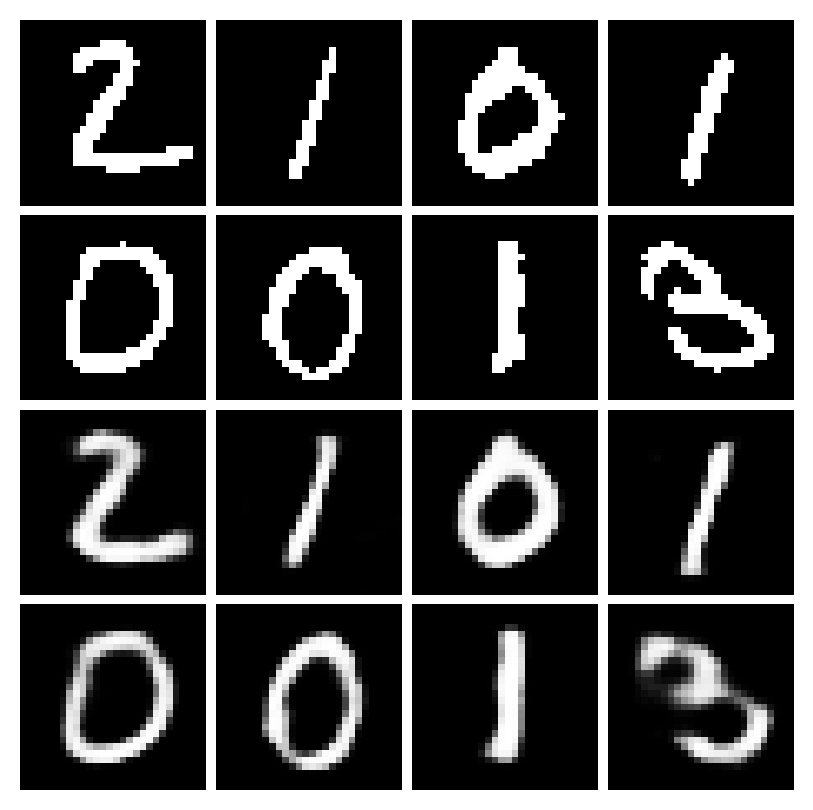

In [13]:
plot_digits(comparison)
plt.show()

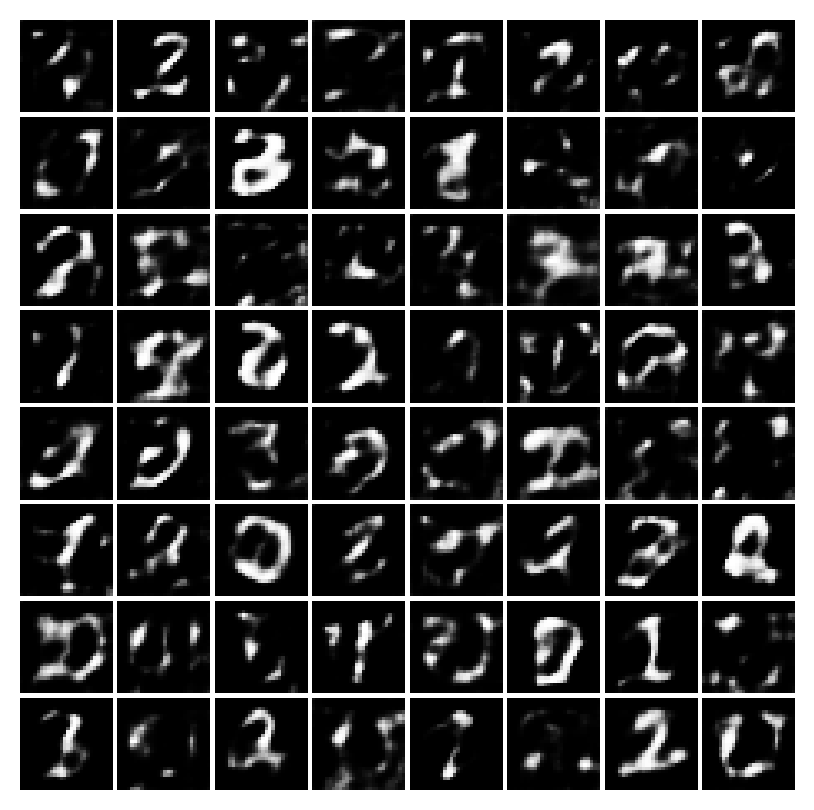

In [14]:
plot_digits(samples)
plt.show()